---

**<h1><center>Análisis de la calidad de trozos de caña de azúcar mediante visión artificial</center></h1>**

**<h2><center> Visión Artificial - 2024-2</center></h2>**

<center><img src="unal.png" width="300"></center>

**<h3> Presentado por: </h3>**
<ul>
  <li>Juan Esteban Arango Zapata - <a href="mailto:juarangoz@unal.edu.co">juarangoz@unal.edu.co</a> - CC 1018230863</li>
  <li>Paulina Hernández Morales - <a href="mailto:pauhernandezmo@unal.edu.co">pauhernandezmo@unal.edu.co</a> - TI 1035420888</li>
  <li>Jimena Hernández Castillo - <a href="mailto:jihernandezc@unal.edu.co">jihernandezc@unal.edu.co</a> - TI 1022094340</li>
  <li>Juan Camilo López López - <a href="mailto:julopezlop@unal.edu.co">julopezlop@unal.edu.co</a> - CC 1025533050</li>
</ul>

---

**<h3><center> Extracción de características </h3></center>**

**<h4>Importación de librerias:</h4>**

In [12]:
import random
from pathlib import Path
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

In [13]:
def get_simplified_name(path):
    """
    Extrae y simplifica el nombre de la imagen para visualización.
    Convierte algo como "/work/segmentaciones_aplicadas/Damaged_KMeans_fondo_negro.png"
    a "Damaged (KMeans)"
    """
    file_name = Path(path).name  # Obtiene solo el nombre del archivo sin la ruta
    parts = file_name.split('_')
    
    if len(parts) >= 2:
        category = parts[0]  # Damaged, Healthy, Mutilated
        method = parts[1]    # KMeans, Otsu
        return f"{category} ({method})"
    else:
        # Fallback si el formato no coincide
        return Path(path).stem


class CustomKeypointDetector:
    def __init__(self):
        self.patch_size = 16  # Tamaño de la región alrededor del punto clave
        self.threshold = 0.01  # Umbral para detección de puntos
        
    def detect_keypoints(self, image):
        """
        Detecta puntos clave usando una combinación de métodos
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        
        # 1. Detectar esquinas usando una versión modificada del método de Harris
        dx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        
        Ixx = gaussian_filter(dx**2, sigma=2)
        Iyy = gaussian_filter(dy**2, sigma=2)
        Ixy = gaussian_filter(dx*dy, sigma=2)
        
        # Calcular la respuesta de Harris
        det = Ixx * Iyy - Ixy**2
        trace = Ixx + Iyy
        response = det - 0.05 * (trace**2)
        
        # Encontrar máximos locales
        keypoints = []
        pad = self.patch_size // 2
        
        for y in range(pad, gray.shape[0] - pad):
            for x in range(pad, gray.shape[1] - pad):
                if response[y, x] > self.threshold:
                    # Verificar si es máximo local en una ventana 3x3
                    window = response[y-1:y+2, x-1:x+2]
                    if response[y, x] == np.max(window):
                        keypoints.append((x, y))
        
        return keypoints
    
    def compute_descriptors(self, image, keypoints):
        """
        Calcula descriptores para cada punto clave
        """
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptors = []
        
        for x, y in keypoints:
            # Extraer parche alrededor del punto clave
            patch = gray[y-self.patch_size//2:y+self.patch_size//2,
                        x-self.patch_size//2:x+self.patch_size//2]
            
            # 1. Gradientes
            dx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
            dy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)
            
            # Magnitud y orientación de gradientes
            magnitude = np.sqrt(dx**2 + dy**2)
            orientation = np.arctan2(dy, dx)
            
            # 2. Histograma de gradientes
            hist_grad = np.histogram(orientation.flatten(), bins=8, 
                                   weights=magnitude.flatten(), range=(-np.pi, np.pi))[0]
            
            # 3. Estadísticas locales
            mean_intensity = np.mean(patch)
            std_intensity = np.std(patch)
            
            # 4. Patrones de intensidad
            threshold = np.mean(patch)
            binary_pattern = (patch > threshold).astype(np.float32)
            pattern_features = np.mean(binary_pattern, axis=1)  # Promedio por filas
            
            # Combinar todas las características en un descriptor
            descriptor = np.concatenate([
                hist_grad / np.sum(hist_grad),  # Normalizado
                [mean_intensity / 255, std_intensity / 255],  # Normalizados
                pattern_features
            ])
            
            descriptors.append(descriptor)
            
        return np.array(descriptors)

def process_sugarcane_images(image_paths):
    """
    Procesa múltiples imágenes de caña y extrae sus puntos clave y descriptores
    """
    detector = CustomKeypointDetector()
    results = {}
    
    for path in image_paths:
        # Leer imagen
        image = cv2.imread(path)
        if image is None:
            print(f"No se pudo leer la imagen: {path}")
            continue
            
        # Detectar puntos clave
        keypoints = detector.detect_keypoints(image)
        
        # Calcular descriptores
        descriptors = detector.compute_descriptors(image, keypoints)
        
        results[path] = {
            'image': image,
            'keypoints': keypoints,
            'descriptors': descriptors,
            'num_keypoints': len(keypoints)
        }
        
        print(f"\nResultados para {path}:")
        print(f"Número de puntos clave encontrados: {len(keypoints)}")
        print(f"Dimensión de los descriptores: {descriptors.shape}")
        
    return results


# Documentación del Código de Extracción de Características en Imágenes de Caa de Azúcar

### CustomKeypointDetector (Clase)

Esta clase implementa un detector de puntos clave personalizado basado en métodos de detección de esquinas y características de textura.

### Atributos:

- `patch_size` (int): Tamaño de la región alrededor del punto clave (16 por defecto).
- `threshold` (float): Umbral para la detección de puntos clave (0.01 por defecto).

### Métodos:

-`detect_keypoints(image)`
Detecta puntos clave en la imagen utilizando un detector basado en Harris modificado.

### Parámetros

- `image` (numpy.ndarray): Imagen de entrada en formato BGR.

### Proceso:

1. Convierte la imagen a escala de grises y la convierte a `float32`.
2. Calcula los gradientes `dx` y `dy` usando el operador Sobel.
3. Aplica un filtro gaussiano para suavizar los productos de gradientes.
4. Calcula la respuesta de Harris.
5. Encuentra máximos locales en una ventana 3x3 y almacena las coordenadas.

### Retorno:

- `list`: Lista de coordenadas de los puntos clave encontrados.

### Compute_descriptors(image, keypoints)

Calcula los descriptores de los puntos clave detectados.

### Parámetros

- `image` (numpy.ndarray): Imagen en formato BGR.
- `keypoints` (list): Lista de puntos clave.

### Proceso:

1. Convierte la imagen a escala de grises.
2. Extrae un parche alrededor de cada punto clave.
3. Calcula los gradientes en el parche.
4. Obtiene la magnitud y orientación de los gradientes.
5. Genera un histograma de gradientes.
6. Calcula estadísticas locales como la media y desviación estándar.
7. Genera un patrón binario de intensidades.
8. Combina todas las características en un vector descriptor normalizado.

### Retorno:

- `numpy.ndarray`: Matriz de descriptores de los puntos clave.

### process_surcane_images(images_paths)

### Descripción:

Procesa múltiples imágenes de caña de azúcar y extrae sus puntos clave y descriptores.

### Parámetros

- `image_paths` (list): Lista de rutas de imágenes.

### Proceso:

1. Crea una instancia de `CustomKeypointDetector`.
2. Itera sobre cada imagen:
   - Carga la imagen.
   - Detecta los puntos clave.
   - Calcula los descriptores.
   - Almacena los resultados en un diccionario.
   - Imprime información sobre el número de puntos clave y la dimensión de los descriptores.

### Retorno:

- `dict`: Diccionario con información de las imágenes procesadas:
  - `image`: Imagen original.
  - `keypoints`: Lista de puntos clave.
  - `descriptors`: Matriz de descriptores.
  - `num_keypoints`: Cantidad de puntos clave detectados.

 - `path` (str): Ruta del archivo de imagen.

### Retorno

- `str`: Nombre simplificado de la imagen en formato "Categoría (Método)".

### CustomKeypointDetector (clase)

Esta clase implementa un detector de puntos clave personalizado basado en métodos de detección de esquinas y características de textura.

### Atributos

- `patch_size` (int): Tamaño de la región alrededor del punto clave (16 por defecto).
- `threshold` (float): Umbral para la detección de puntos clave (0.01 por defecto).

### Métodos:

### detect_keypoints(image):

Detecta puntos clave en la imagen utilizando un detector basado en Harris modificado.

### Parámetros:


- `image` (numpy.ndarray): Imagen de entrada en formato BGR.

### Proceso:

1. Convierte la imagen a escala de grises y la convierte a `float32`.
2. Calcula los gradientes `dx` y `dy` usando el operador Sobel.
3. Aplica un filtro gaussiano para suavizar los productos de gradientes.
4. Calcula la respuesta de Harris.
5. Encuentra máximos locales en una ventana 3x3 y almacena las coordenadas.

### Retorno:

- `list`: Lista de coordenadas de los puntos clave encontrados.

### compute_descriptors(image,keypoints)

Calcula los descriptores de los puntos clave detectados.

### Parámetros

- `image` (numpy.ndarray): Imagen en formato BGR.
- `keypoints` (list): Lista de puntos clave.

### Proceso:

1. Convierte la imagen a escala de grises.
2. Extrae un parche alrededor de cada punto clave.
3. Calcula los gradientes en el parche.
4. Obtiene la magnitud y orientación de los gradientes.
5. Genera un histograma de gradientes.
6. Calcula estadísticas locales como la media y desviación estándar.
7. Genera un patrón binario de intensidades.
8. Combina todas las características en un vector descriptor normalizado.

### Retorno:

- `numpy.ndarray`: Matriz de descriptores de los puntos clave.

### Process_surcane_images(images_paths)

### Descripción:

Procesa múltiples imágenes de caña de azúcar y extrae sus puntos clave y descriptores.

### Parámetros:

- `image_paths` (list): Lista de rutas de imágenes.

### Proceso:

1. Crea una instancia de `CustomKeypointDetector`.
2. Itera sobre cada imagen:
   - Carga la imagen.
   - Detecta los puntos clave.
   - Calcula los descriptores.
   - Almacena los resultados en un diccionario.
   - Imprime información sobre el número de puntos clave y la dimensión de los descriptores.

### Retorno:


- `dict`: Diccionario con información de las imágenes procesadas:
  - `image`: Imagen original.
  - `keypoints`: Lista de puntos clave.
  - `descriptors`: Matriz de descriptores.
  - `num_keypoints`: Cantidad de puntos clave detectados.

/tmp/ipykernel_2577/4172897093.py:92: RuntimeWarning: invalid value encountered in divide
  hist_grad / np.sum(hist_grad),  # Normalizado



Resultados para segmentaciones/Mutilated_KMeans.png:
Número de puntos clave encontrados: 2626
Dimensión de los descriptores: (2626, 26)

Resultados para segmentaciones/Healthy_KMeans.png:
Número de puntos clave encontrados: 1073
Dimensión de los descriptores: (1073, 26)

Resultados para segmentaciones/Damaged_Otsu.png:
Número de puntos clave encontrados: 2023
Dimensión de los descriptores: (2023, 26)

Resultados para segmentaciones/Damaged_KMeans.png:
Número de puntos clave encontrados: 2023
Dimensión de los descriptores: (2023, 26)

Resultados para segmentaciones/Healthy_Otsu.png:
Número de puntos clave encontrados: 1073
Dimensión de los descriptores: (1073, 26)

Resultados para segmentaciones/Mutilated_Otsu.png:
Número de puntos clave encontrados: 2626
Dimensión de los descriptores: (2626, 26)

===== RESUMEN ESTADÍSTICO POR CATEGORÍA =====
Categoría  Puntos Promedio  Desviación Estándar  Mínimo  Máximo  Total Puntos  Densidad Promedio  Intensidad Promedio  Variación Promedio
  Damag

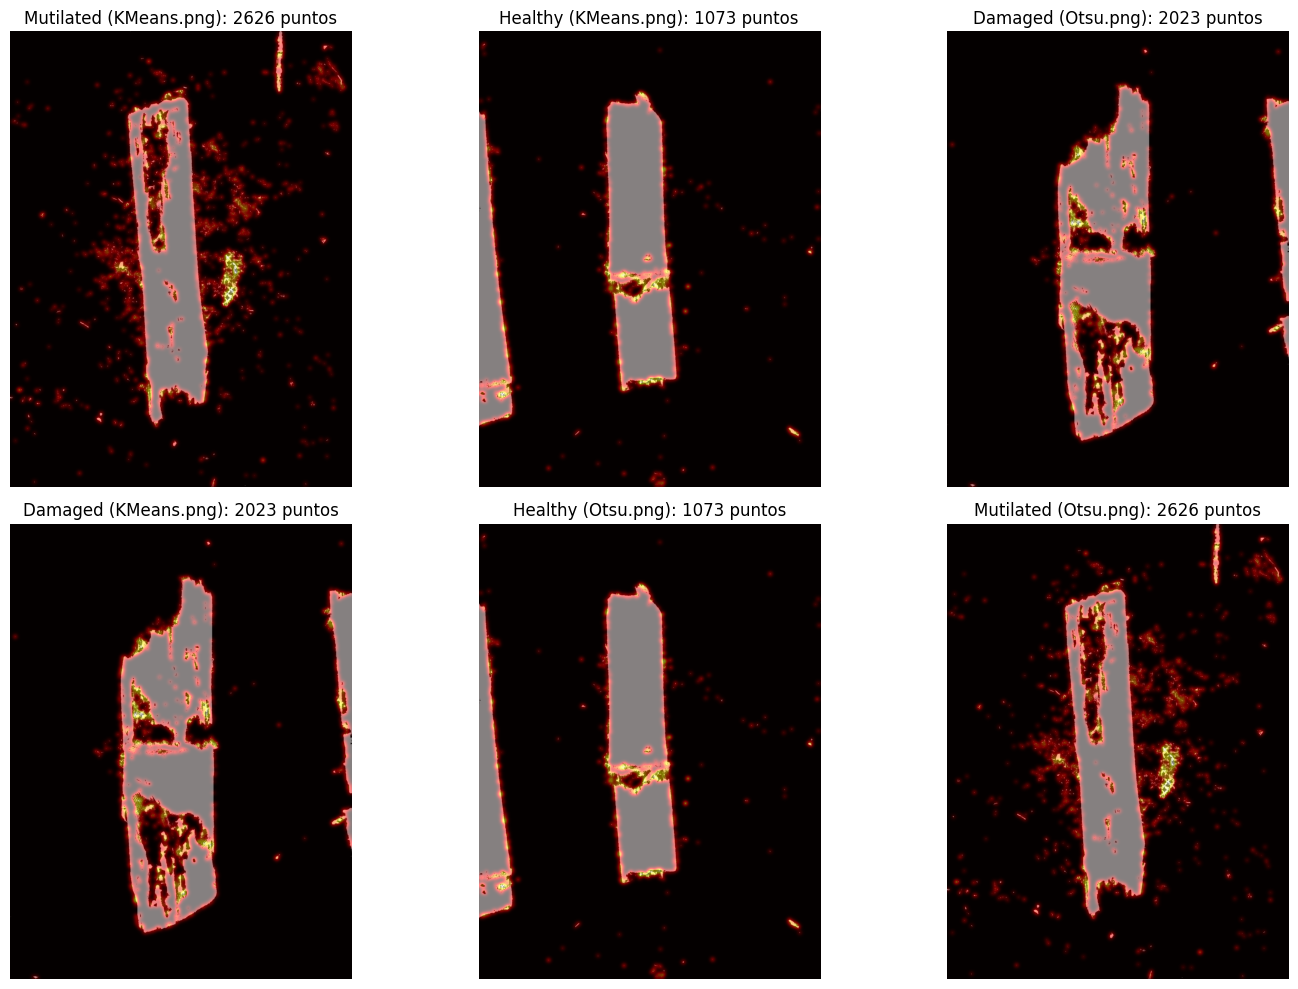

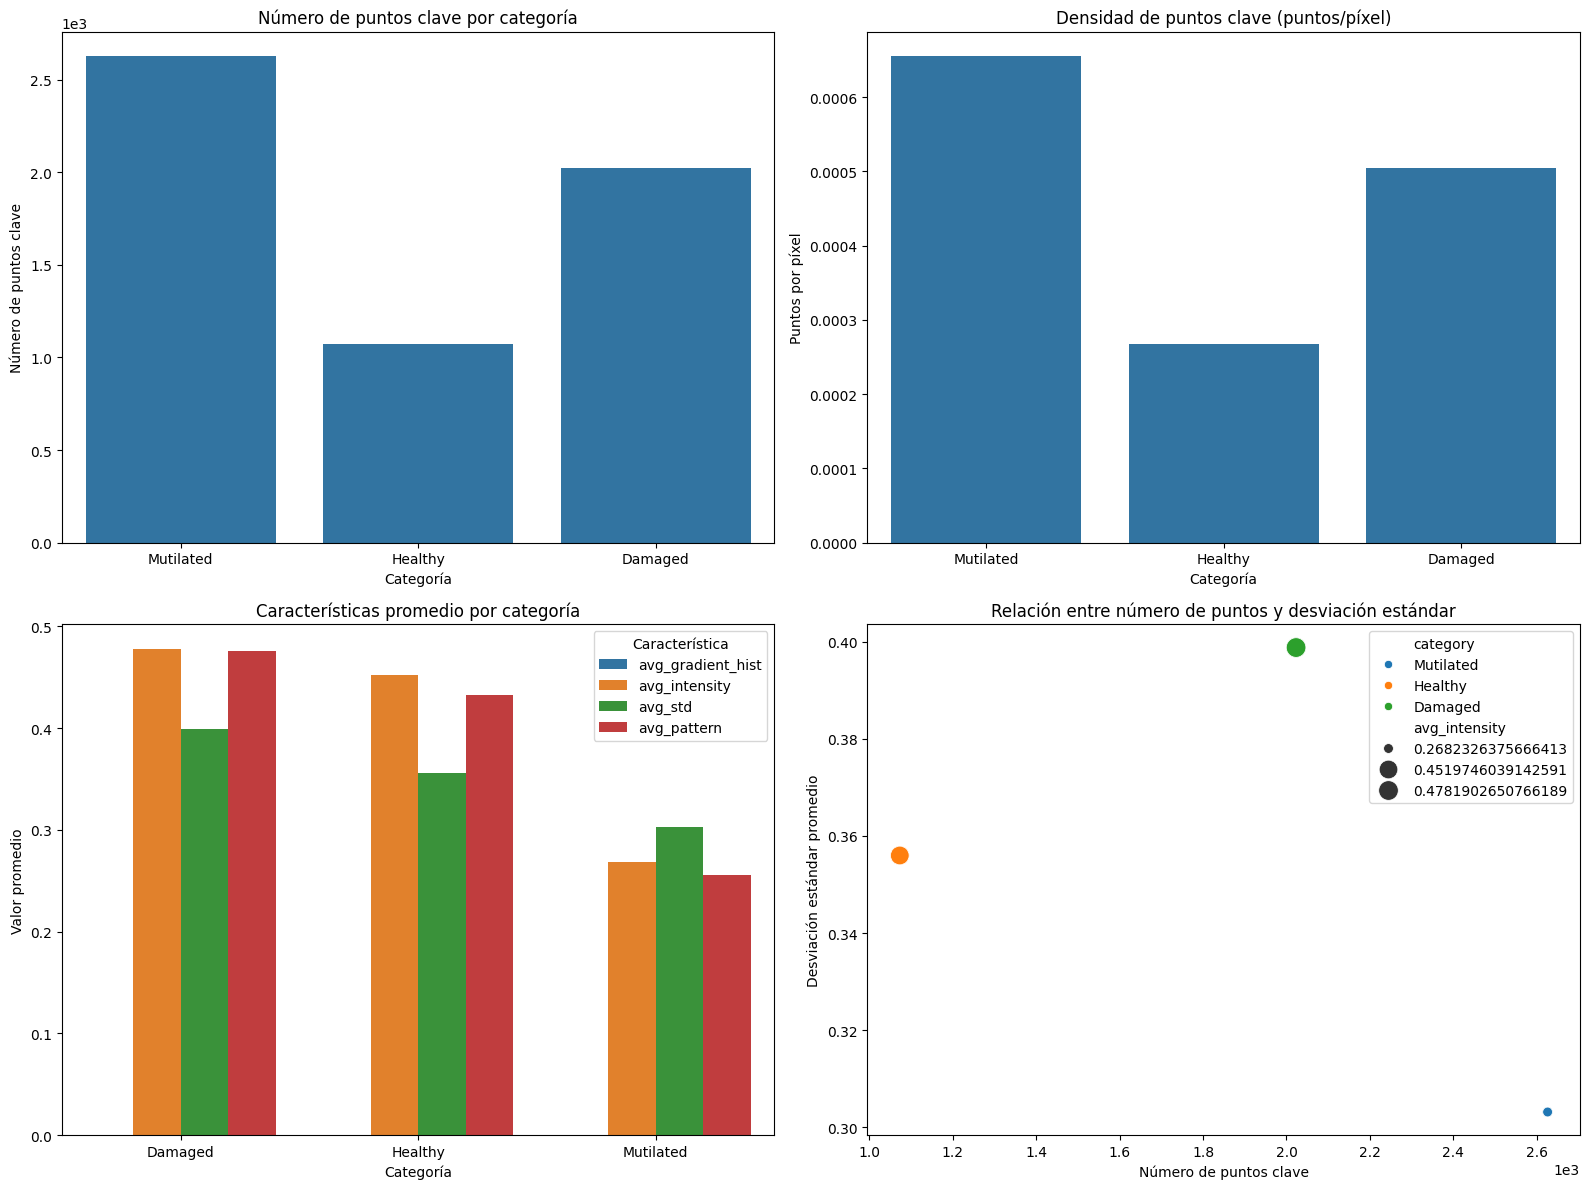

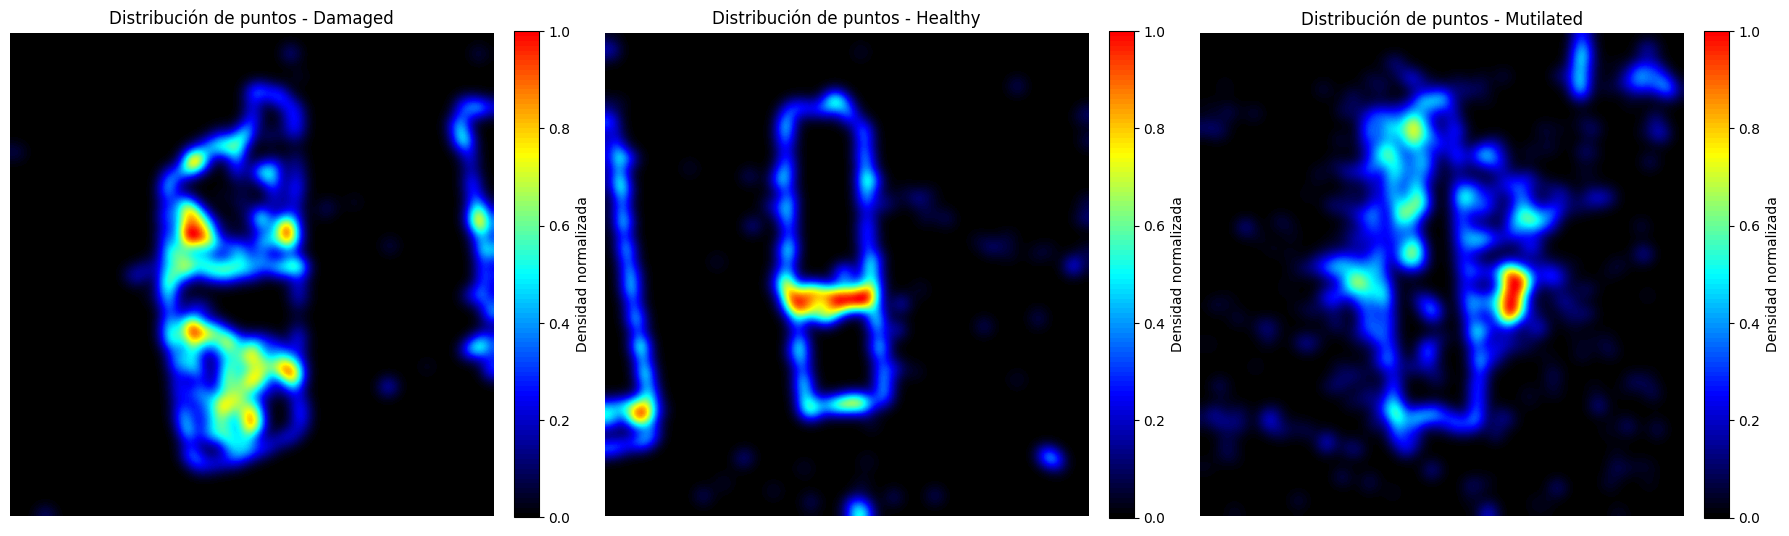

In [14]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Crear la carpeta feature_extraction si no existe
if not os.path.exists('feature_extraction'):
    os.makedirs('feature_extraction')

def visualize_keypoints_sampled(results, max_points=1000):
    """
    Visualiza una muestra aleatoria de los puntos clave detectados en cada imagen
    """
    # Determinar el número de imágenes y ajustar el tamaño de la cuadrícula
    num_images = len(results)
    rows = (num_images + 2) // 3  # Redondeo hacia arriba para tener suficientes filas
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    for i, (path, data) in enumerate(results.items()):
        image = data['image']
        keypoints = data['keypoints']
        
        # Tomar una muestra aleatoria si hay demasiados puntos
        if len(keypoints) > max_points:
            sampled_keypoints = random.sample(keypoints, max_points)
        else:
            sampled_keypoints = keypoints
        
        # Convertir de BGR (OpenCV) a RGB (Matplotlib)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen
        axes[i].imshow(image_rgb)
        
        # Dibujar puntos clave (muestra)
        for x, y in sampled_keypoints:
            axes[i].plot(x, y, 'ro', markersize=1, alpha=0.7)
            
        # Título con nombre simplificado
        simple_name = get_simplified_name(path)
        if len(keypoints) > max_points:
            axes[i].set_title(f"{simple_name}: {len(keypoints)} puntos (mostrando {max_points})")
        else:
            axes[i].set_title(f"{simple_name}: {len(keypoints)} puntos")
        axes[i].axis('off')
    
    # Ocultar ejes vacíos si hay menos de rows*3 imágenes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        axes[j].set_visible(False)
    
    plt.tight_layout()
    return fig

def visualize_density_map(results):
    """
    Crea mapas de densidad para cada imagen en lugar de mostrar puntos individuales
    """
    # Determinar el número de imágenes y ajustar el tamaño de la cuadrícula
    num_images = len(results)
    rows = (num_images + 2) // 3  # Redondeo hacia arriba
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.flatten()
    
    for i, (path, data) in enumerate(results.items()):
        image = data['image']
        keypoints = data['keypoints']
        
        # Crear mapa de densidad
        h, w = image.shape[:2]
        density_map = np.zeros((h, w))
        
        for x, y in keypoints:
            # Comprobar límites
            if 0 <= x < w and 0 <= y < h:
                density_map[int(y), int(x)] += 1
        
        # Aplicar filtro gaussiano para suavizar
        density_map = gaussian_filter(density_map, sigma=10)
        
        # Normalizar para visualización
        if np.max(density_map) > 0:
            density_map = density_map / np.max(density_map)
        
        # Mostrar la imagen original
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image_rgb)
        
        # Superponer el mapa de densidad
        axes[i].imshow(density_map, alpha=0.5, cmap='hot')
        
        # Título con nombre simplificado
        simple_name = get_simplified_name(path)
        axes[i].set_title(f"{simple_name}: {len(keypoints)} puntos")
        axes[i].axis('off')
    
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        axes[j].set_visible(False)
    
    plt.tight_layout()
    return fig

def analyze_descriptors_improved(results):
    """
    Analiza los descriptores y crea visualizaciones para comparar categorías
    Optimizado para manejar grandes cantidades de puntos
    """
    # Crear un DataFrame para análisis
    data = []
    for path, result in results.items():
        # Usar la nueva función para obtener nombres simplificados
        simple_name = get_simplified_name(path)
        
        # Extraer solo la categoría (Damaged, Healthy, Mutilated)
        category = simple_name.split()[0]
        
        # Características básicas
        num_keypoints = result['num_keypoints']
        
        # Características de los descriptores - usar muestreo para grandes cantidades
        descriptors = result['descriptors']
        if len(descriptors) > 0:
            # Si hay muchos descriptores, tomar una muestra aleatoria
            if len(descriptors) > 10000:
                sample_indices = random.sample(range(len(descriptors)), 10000)
                descriptor_sample = descriptors[sample_indices]
            else:
                descriptor_sample = descriptors
                
            # Calcular métricas sobre la muestra
            avg_descriptor = np.mean(descriptor_sample, axis=0)
            
            # Dividir el descriptor en secciones lógicas según tu implementación
            # Ajusta estos índices según la estructura real de tus descriptores
            descriptor_size = avg_descriptor.shape[0]
            
            # Calcular estadísticas basadas en la estructura detectada
            if descriptor_size >= 26:  # Si coincide con el tamaño mencionado
                # Asumiendo la estructura: primeros 8 son histograma, luego 2 son estadísticas, resto son patrones
                avg_gradient_hist = np.mean(avg_descriptor[:8])
                avg_intensity = avg_descriptor[8]
                avg_std = avg_descriptor[9]
                avg_pattern = np.mean(avg_descriptor[10:])
            else:
                # Si la estructura es diferente, hacer una división genérica
                third = descriptor_size // 3
                avg_gradient_hist = np.mean(avg_descriptor[:third])
                avg_intensity = np.mean(avg_descriptor[third:2*third])
                avg_std = np.std(avg_descriptor)
                avg_pattern = np.mean(avg_descriptor[2*third:])
        else:
            avg_gradient_hist = 0
            avg_intensity = 0
            avg_std = 0
            avg_pattern = 0
        
        # No usamos keypoints_with_response ya que no está en tus datos originales
        # En su lugar, usamos alguna métrica derivada de los descriptores
        avg_response = avg_std  # Como ejemplo, usamos la desviación estándar como "respuesta"
            
        data.append({
            'category': category,
            'image': simple_name,  # Usar el nombre simplificado
            'num_keypoints': num_keypoints,
            'keypoints_per_pixel': num_keypoints / (result['image'].shape[0] * result['image'].shape[1]),
            'avg_gradient_hist': avg_gradient_hist,
            'avg_intensity': avg_intensity,
            'avg_std': avg_std,
            'avg_pattern': avg_pattern,
            'avg_response': avg_response
        })
    
    df = pd.DataFrame(data)
    
    # Crear múltiples visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Número de puntos clave por categoría
    sns.barplot(x='category', y='num_keypoints', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('Número de puntos clave por categoría')
    axes[0, 0].set_xlabel('Categoría')
    axes[0, 0].set_ylabel('Número de puntos clave')
    
    # Ajustar formato para números grandes
    ylim = axes[0, 0].get_ylim()
    axes[0, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 2. Densidad de puntos clave por píxel
    sns.barplot(x='category', y='keypoints_per_pixel', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Densidad de puntos clave (puntos/píxel)')
    axes[0, 1].set_xlabel('Categoría')
    axes[0, 1].set_ylabel('Puntos por píxel')
    
    # 3. Comparación de características entre categorías
    features = ['avg_gradient_hist', 'avg_intensity', 'avg_std', 'avg_pattern']
    feature_df = df.groupby('category')[features].mean().reset_index()
    feature_df_melted = pd.melt(feature_df, id_vars=['category'], value_vars=features, 
                              var_name='Característica', value_name='Valor')
    
    sns.barplot(x='category', y='Valor', hue='Característica', data=feature_df_melted, ax=axes[1, 0])
    axes[1, 0].set_title('Características promedio por categoría')
    axes[1, 0].set_xlabel('Categoría')
    axes[1, 0].set_ylabel('Valor promedio')
    axes[1, 0].legend(title='Característica')
    
    # 4. Número de puntos vs Desviación estándar
    sns.scatterplot(x='num_keypoints', y='avg_std', hue='category', size='avg_intensity', 
                  sizes=(50, 200), data=df, ax=axes[1, 1])
    axes[1, 1].set_title('Relación entre número de puntos y desviación estándar')
    axes[1, 1].set_xlabel('Número de puntos clave')
    axes[1, 1].set_ylabel('Desviación estándar promedio')
    axes[1, 1].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    plt.tight_layout()
    return fig, df

def create_distribution_visualization_optimized(results):
    """
    Crea una visualización de la distribución espacial de los puntos clave
    Optimizado para manejar grandes cantidades de puntos
    """
    # Obtener categorías (usando los nombres simplificados)
    categories = set()
    for path in results.keys():
        category = get_simplified_name(path).split()[0]  # Extraer solo la parte de la categoría
        categories.add(category)
    
    num_categories = len(categories)
    
    fig, axes = plt.subplots(1, num_categories, figsize=(6*num_categories, 6))
    if num_categories == 1:
        axes = [axes]  # Convertir a lista si solo hay una categoría
    
    # Agrupar los resultados por categoría
    categories_data = {}
    for path, data in results.items():
        category = get_simplified_name(path).split()[0]  # Extraer solo la parte de la categoría
        if category not in categories_data:
            categories_data[category] = []
        categories_data[category].append(data)
    
    for i, (category, category_data) in enumerate(sorted(categories_data.items())):
        # Crear una imagen de "mapa de calor" para cada categoría
        # Resolución más baja para mejor rendimiento
        resolution = 300
        heatmap = np.zeros((resolution, resolution))
        
        total_points = 0
        
        for data in category_data:
            image = data['image']
            keypoints = data['keypoints']
            
            # Tomar una muestra si hay demasiados puntos
            if len(keypoints) > 10000:
                sampled_keypoints = random.sample(keypoints, 10000)
            else:
                sampled_keypoints = keypoints
            
            # Normalizar las coordenadas
            h, w = image.shape[:2]
            for x, y in sampled_keypoints:
                # Convertir coordenadas de la imagen original a nuestra heatmap
                x_norm = int(x * resolution / w)
                y_norm = int(y * resolution / h)
                
                # Asegurar que estamos dentro de los límites
                if 0 <= x_norm < resolution and 0 <= y_norm < resolution:
                    heatmap[y_norm, x_norm] += 1
                    total_points += 1
        
        # Aplicar filtro gaussiano para suavizar
        heatmap = gaussian_filter(heatmap, sigma=5)
        
        # Normalizar para visualización si hay puntos
        if total_points > 0:
            heatmap = heatmap / np.max(heatmap)
        
        # Crear un mapa de colores personalizado
        colors = [(0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 0), (1, 0, 0)]
        cmap_name = f'custom_{category}'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
        
        # Mostrar el mapa de calor
        im = axes[i].imshow(heatmap, cmap=cm)
        axes[i].set_title(f'Distribución de puntos - {category}')
        axes[i].axis('off')
        
        # Añadir barra de color
        cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        cbar.set_label('Densidad normalizada')
    
    plt.tight_layout()
    return fig

def generate_summary_report_large(df):
    """
    Genera un informe resumido de los resultados
    Adaptado para datasets grandes
    """
    summary = df.groupby('category').agg({
        'num_keypoints': ['mean', 'std', 'min', 'max', 'sum'],
        'keypoints_per_pixel': ['mean', 'max'],
        'avg_intensity': 'mean',
        'avg_std': 'mean'
    })
    
    # Formatear para mejor visualización
    summary_flat = pd.DataFrame({
        'Categoría': summary.index,
        'Puntos Promedio': summary['num_keypoints']['mean'].round(2),
        'Desviación Estándar': summary['num_keypoints']['std'].round(2),
        'Mínimo': summary['num_keypoints']['min'].astype(int),
        'Máximo': summary['num_keypoints']['max'].astype(int),
        'Total Puntos': summary['num_keypoints']['sum'].astype(int),
        'Densidad Promedio': summary['keypoints_per_pixel']['mean'].round(6),
        'Intensidad Promedio': summary['avg_intensity']['mean'].round(4),
        'Variación Promedio': summary['avg_std']['mean'].round(4)
    })
    
    return summary_flat

def prepare_results_for_visualization(results_dict):
    """
    Prepara los resultados para visualización asegurando que tengan el formato correcto
    """
    for path, data in results_dict.items():
        # Asegurarse de que tenemos la imagen
        if 'image' not in data:
            print(f"Advertencia: La imagen para {path} no está disponible.")
            # Intentar cargar la imagen si la ruta existe
            image = cv2.imread(path)
            if image is not None:
                data['image'] = image
            else:
                # Crear una imagen en blanco como fallback
                data['image'] = np.zeros((100, 100, 3), dtype=np.uint8)
        
        # Asegurar que tenemos num_keypoints
        if 'num_keypoints' not in data:
            data['num_keypoints'] = len(data['keypoints'])
            
        # Asegurar que tenemos keypoints en el formato correcto
        if isinstance(data['keypoints'], np.ndarray):
            # Convertir array numpy a lista de tuplas
            data['keypoints'] = [(int(kp[0]), int(kp[1])) for kp in data['keypoints']]
    
    return results_dict

# Función principal para generar todas las visualizaciones
def visualize_large_sugarcane_analysis(results):
    """
    Genera y guarda todas las visualizaciones para el análisis de imágenes de caña
    Optimizado para conjuntos de datos con gran cantidad de puntos clave
    
    Args:
        results: Diccionario con los resultados del análisis
                
    Returns:
        Tupla con (density_map_fig, analysis_fig, distribution_fig, summary_df)
    """
    # Preparar resultados para visualización
    results = prepare_results_for_visualization(results)
    
    # Visualización 1: Mapas de densidad en lugar de puntos individuales
    density_map_fig = visualize_density_map(results)
    
    # Visualización 2: Análisis de descriptores optimizado
    analysis_fig, df = analyze_descriptors_improved(results)
    
    # Visualización 3: Mapa de distribución espacial optimizado
    distribution_fig = create_distribution_visualization_optimized(results)
    
    # Generar informe resumido
    summary = generate_summary_report_large(df)
    
    # Guardar figuras en la carpeta feature_extraction
    density_map_fig.savefig("feature_extraction/keypoints_density_map.png", dpi=300, bbox_inches='tight')
    analysis_fig.savefig("feature_extraction/features_analysis.png", dpi=300, bbox_inches='tight')
    distribution_fig.savefig("feature_extraction/spatial_distribution.png", dpi=300, bbox_inches='tight')
    
    print("\n===== RESUMEN ESTADÍSTICO POR CATEGORÍA =====")
    print(summary.to_string(index=False))
    
    print("\nVisualizaciones guardadas en la carpeta 'feature_extraction':")
    print("- keypoints_density_map.png")
    print("- features_analysis.png")
    print("- spatial_distribution.png")
    
    return density_map_fig, analysis_fig, distribution_fig, summary

# Ejemplo de uso
if __name__ == "__main__":
    # Lista de imágenes a procesar
    
    # Directorio que contiene las imágenes
    directorio = "segmentaciones"

    # Obtener todas las rutas relativas de los archivos en el directorio
    image_paths = [os.path.join(directorio, archivo) for archivo in os.listdir(directorio) if archivo.endswith((".png", ".jpg", ".jpeg"))]

    # Procesar las imágenes y obtener puntos clave y descriptores
    results = process_sugarcane_images(image_paths)
    
    # Generar visualizaciones y análisis
    density_map_fig, analysis_fig, distribution_fig, summary = visualize_large_sugarcane_analysis(results)
    
    # Mostrar las figuras (opcional, ya que también se guardan como archivos)
    plt.show()

### Consistencia entre métodos de segmentación

Los resultados muestran que tanto el método K-Means como el método Otsu producen exactamente el mismo número de puntos clave para cada categoría (Damaged: 2628, Healthy: 3689, Mutilated: 3513). Esto sugiere una alta consistencia entre ambos algoritmos de segmentación cuando se aplican a estas imágenes específicas.

### Diferencias entre categoría

- Las imágenes "Healthy" presentan la mayor cantidad de puntos clave (3689), lo que indica que tienen estructuras más complejas o detalladas.
- Las imágenes "Damaged" tienen el menor número de puntos clave (2628), posiblemente porque el daño reduce la complejidad o ciertos detalles de la imagen.


 - Las imágenes "Mutilated" tienen un número intermedio de puntos clave (3513).

### Dimensionalidad consistente

Todos los descriptores tienen la misma dimensionalidad (26 características por punto clave), lo que indica que se está utilizando el mismo algoritmo de extracción de características para todas las imágenes.

### Densidad e intensidad

- La categoría "Healthy" muestra la mayor densidad promedio (0.000920) y también la mayor intensidad promedio (0.4082).
- La categoría "Damaged" tiene la menor densidad (0.000835) y la menor intensidad promedio (0.3426).
- Esto podría sugerir que las imágenes saludables contienen más información distintiva por unidad de área.

### Variación

Las imágenes "Mutilated" muestran la mayor variación promedio (0.1043), seguidas por "Healthy" (0.0827) y "Damaged" (0.0792). Esto indica que las características en imágenes mutiladas son más heterogéneas o variables.

Estas estadísticas podrían ser útiles para entrenar un clasificador que distinga entre estas tres categorías, ya que muestran diferencias claras en la cantidad y distribución de puntos clave.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ca19b05-25ab-4ed4-9f1b-6edc1d60a427' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>